In [ ]:
#!/usr/bin/env python3
"""
Risk Analytics on all_stocks_5yr.csv

- Loads OHLCV data from /mnt/data/all_stocks_5yr.csv
- Builds an equal-weight (or user-specified) portfolio
- Computes Historical VaR & CVaR
- Computes Parametric (Normal) VaR
- Stress scenarios:
    1) Historical worst days
    2) Uniform equity shocks
    3) Correlation-breakdown VaR
"""

import os
import json
from typing import List, Dict, Optional

import numpy as np
import pandas as pd
from scipy.stats import norm


# --------------------------- Configuration ---------------------------

CONFIG = {
    "csv_path": "/content/drive/MyDrive/Datasets/S&P 500 stocks/all_stocks_5yr.csv",
    "price_col": "close",
    "date_col": "date",
    "ticker_col": "Name",
    "tickers": ["AAPL","MSFT","AMZN","GOOGL"],
    "weights": [0.25,0.25,0.25,0.25],
    "conf_levels": [0.95, 0.99],
    "worst_k": 5,
    "uniform_shocks": [-0.02, -0.05, -0.10],
    "outdir": "/content/drive/MyDrive/Datasets/risk_var_cvar_calculations/outputs"
}


# --------------------------- Data Loading ----------------------------

def load_price_panel(cfg: dict) -> pd.DataFrame:
    df = pd.read_csv(cfg["csv_path"])
    ticker_col = cfg["ticker_col"] if cfg["ticker_col"] in df.columns else (
        "symbol" if "symbol" in df.columns else cfg["ticker_col"]
    )
    date_col = cfg["date_col"]

    missing = [c for c in [date_col, ticker_col, cfg["price_col"]] if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required column(s): {missing}")

    df[date_col] = pd.to_datetime(df[date_col])
    df = df[[date_col, ticker_col, cfg["price_col"]]].copy()

    if cfg["tickers"]:
        df = df[df[ticker_col].isin(cfg["tickers"])]

    panel = df.pivot(index=date_col, columns=ticker_col, values=cfg["price_col"])
    return panel.sort_index().dropna(axis=1, how="all")


def compute_returns(panel: pd.DataFrame) -> pd.DataFrame:
    return panel.pct_change().dropna(how="all")


# ------------------------ Portfolio Construction ---------------------

def normalize_weights(tickers: List[str], weights: Optional[List[float]]) -> np.ndarray:
    if weights is None:
        return np.full(len(tickers), 1.0 / len(tickers))
    w = np.asarray(weights, dtype=float)
    if len(w) != len(tickers):
        raise ValueError("Length of weights must match number of tickers.")
    return w / w.sum()


def portfolio_returns(rets: pd.DataFrame, weights: np.ndarray) -> pd.Series:
    clean = rets.dropna(how="any")
    return pd.Series(clean.values @ weights, index=clean.index, name="portfolio_return")


# --------------------------- Risk Metrics ----------------------------

def var_cvar(returns: pd.Series, cl: float = 0.95) -> Dict[str, float]:
    q = np.quantile(returns, 1 - cl)
    cvar = returns[returns <= q].mean() if np.any(returns <= q) else q
    return {"VaR": -float(q), "CVaR": -float(cvar)}


def parametric_var(returns: pd.Series, cl: float = 0.95) -> Dict[str, float]:
    mu, sigma = returns.mean(), returns.std(ddof=1)
    return {"VaR": -(mu + sigma * norm.ppf(1 - cl)), "mu": float(mu), "sigma": float(sigma)}


# --------------------------- Stress Tests ----------------------------

def historical_worst_days(returns: pd.Series, k: int = 5) -> List[Dict]:
    worst = returns.nsmallest(k)
    return [{"date": d.strftime("%Y-%m-%d"), "return": float(v)} for d, v in worst.items()]


def uniform_shock_impact(weights: np.ndarray, shocks: List[float]) -> List[Dict]:
    return [{"shock": s, "portfolio_return": float(weights.sum() * s)} for s in shocks]


def corr_breakdown_parametric_var(rets: pd.DataFrame, weights: np.ndarray, cl: float = 0.95, target_corr: float = 0.9) -> Dict[str, float]:
    mu_vec, std_vec = rets.mean().values, rets.std(ddof=1).values
    cov_stressed = np.outer(std_vec, std_vec) * target_corr
    np.fill_diagonal(cov_stressed, std_vec**2)

    mu_p = float(weights @ mu_vec)
    sigma_p = float(np.sqrt(weights @ cov_stressed @ weights))
    var_stressed = -(mu_p + sigma_p * norm.ppf(1 - cl))
    return {"VaR": var_stressed, "mu": mu_p, "sigma": sigma_p, "target_corr": target_corr}


# ------------------------------ Main --------------------------------

def main(cfg: dict):
    os.makedirs(cfg["outdir"], exist_ok=True)

    prices = load_price_panel(cfg)
    if cfg["tickers"]:
        prices = prices[cfg["tickers"]]

    returns_df = compute_returns(prices)
    tickers = cfg["tickers"] or list(returns_df.columns)
    weights = normalize_weights(tickers, cfg["weights"])
    port_ret = portfolio_returns(returns_df[tickers], weights)

    historical = {str(int(cl*100)): var_cvar(port_ret, cl) for cl in cfg["conf_levels"]}
    parametric = {str(int(cl*100)): parametric_var(port_ret, cl) for cl in cfg["conf_levels"]}

    worst_days = historical_worst_days(port_ret, k=cfg["worst_k"])
    uniform_impacts = uniform_shock_impact(weights, cfg["uniform_shocks"])
    corr_stress = {str(int(cl*100)): corr_breakdown_parametric_var(returns_df[tickers], weights, cl, 0.9) for cl in cfg["conf_levels"]}

    port_ret.to_csv(os.path.join(cfg["outdir"], "portfolio_returns.csv"))
    report = {
        "meta": {"n_days": len(port_ret), "n_assets": len(tickers), "tickers": tickers, "weights": list(weights)},
        "Historical": historical,
        "Parametric": parametric,
        "Stress": {"historical_worst_days": worst_days, "uniform_shocks": uniform_impacts, "corr_breakdown": corr_stress}
    }
    with open(os.path.join(cfg["outdir"], "risk_report.json"), "w") as f:
        json.dump(report, f, indent=2)

    print("✅ Risk analysis complete.")


if __name__ == "__main__":
    main(CONFIG)


✅ Risk analysis complete.


In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

def plot_risk_report(outdir="/content/drive/MyDrive/Datasets/risk_var_cvar_calculations/outputs"):
    """
    Load portfolio_returns.csv and risk_report.json from `outdir`
    and produce summary plots:
      1. Portfolio return time series with worst days highlighted
      2. Histogram of returns with VaR / CVaR lines
      3. Bar chart of uniform shock stress test impacts
      4. Correlation breakdown stressed VaR vs normal parametric VaR
    """
    # ---------------- Load data ----------------
    ret_path = os.path.join(outdir, "portfolio_returns.csv")
    json_path = os.path.join(outdir, "risk_report.json")

    if not (os.path.exists(ret_path) and os.path.exists(json_path)):
        raise FileNotFoundError("Missing portfolio_returns.csv or risk_report.json in outputs folder.")

    port_ret = pd.read_csv(ret_path, index_col=0, parse_dates=True)["portfolio_return"]
    with open(json_path, "r") as f:
        report = json.load(f)

    # ---------------- Plot time series ----------------
    plt.figure(figsize=(12, 5))
    plt.plot(port_ret.index, port_ret.values, label="Portfolio Return", color="blue")

    # Highlight worst days
    worst_days = report["Stress"]["historical_worst_days"]
    for wd in worst_days:
        d = pd.to_datetime(wd["date"])
        plt.axvline(d, color="red", linestyle="--", alpha=0.6)
    plt.title("Portfolio Returns with Worst Days Highlighted")
    plt.xlabel("Date")
    plt.ylabel("Daily Return")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ---------------- Histogram with VaR / CVaR ----------------
    plt.figure(figsize=(8, 5))
    plt.hist(port_ret, bins=50, color="skyblue", edgecolor="black", alpha=0.7)
    for cl, vals in report["Historical"].items():
        plt.axvline(-vals["VaR"], color="red", linestyle="--", label=f"VaR {cl}%")
        plt.axvline(-vals["CVaR"], color="purple", linestyle=":", label=f"CVaR {cl}%")
    plt.title("Distribution of Portfolio Returns with VaR / CVaR")
    plt.xlabel("Daily Return")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ---------------- Uniform Shock Impacts ----------------
    shocks = report["Stress"]["uniform_shocks"]
    shock_vals = [d["portfolio_return"] for d in shocks]
    shock_labels = [f"{int(d['shock']*100)}%" for d in shocks]

    plt.figure(figsize=(7, 5))
    plt.bar(shock_labels, shock_vals, color="orange", edgecolor="black")
    plt.title("Uniform Shock Scenario Impacts")
    plt.xlabel("Shock to All Assets")
    plt.ylabel("Portfolio Return")
    plt.grid(True, axis="y")
    plt.show()

    # ---------------- Correlation Breakdown Stress ----------------
    corr_stress = report["Stress"]["corr_breakdown"]
    parametric = report["Parametric"]

    cl_list = sorted([int(k) for k in corr_stress.keys()])
    normal_vars = [parametric[str(cl)]["VaR"] for cl in cl_list]
    stressed_vars = [corr_stress[str(cl)]["VaR"] for cl in cl_list]

    x = range(len(cl_list))
    plt.figure(figsize=(8, 5))
    plt.bar(x, normal_vars, width=0.4, label="Normal Parametric VaR")
    plt.bar([i+0.4 for i in x], stressed_vars, width=0.4, label="Corr Breakdown VaR")
    plt.xticks([i+0.2 for i in x], [f"{cl}%" for cl in cl_list])
    plt.title("Correlation Breakdown Stress Test")
    plt.ylabel("VaR")
    plt.legend()
    plt.grid(True, axis="y")
    plt.show()

    print("📊 Plots generated successfully.")



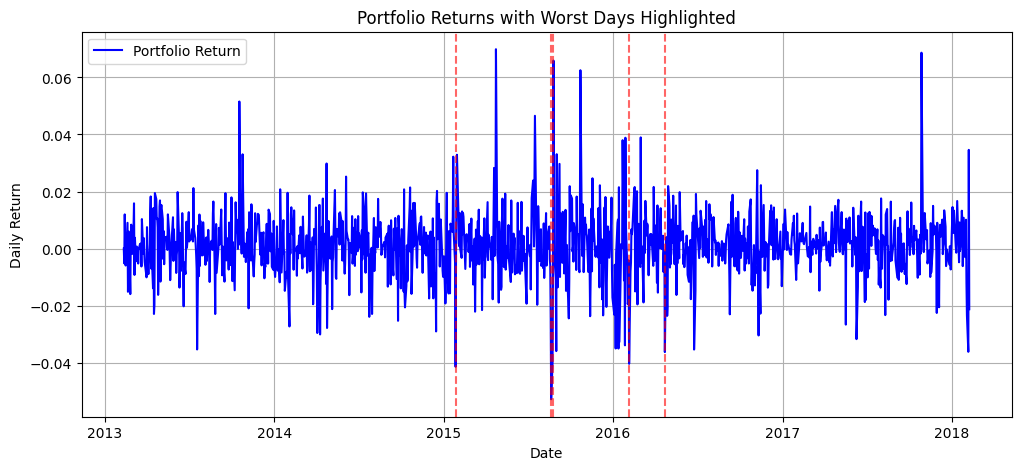

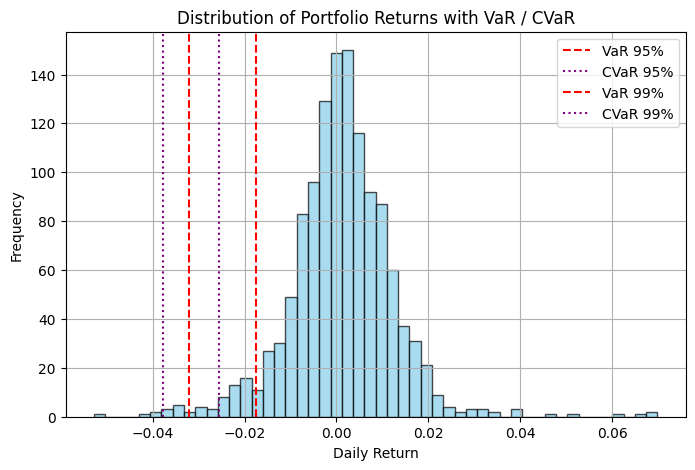

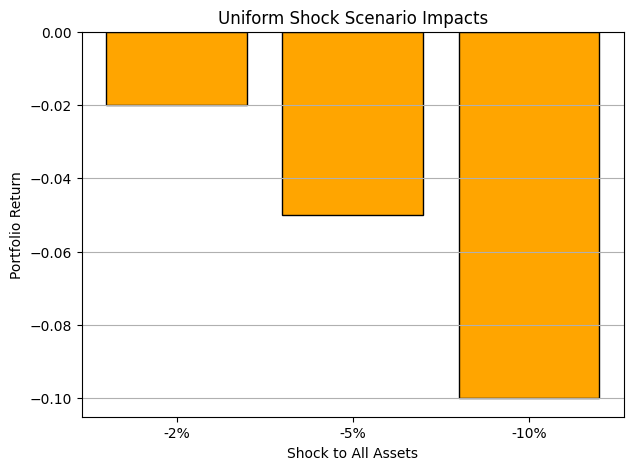

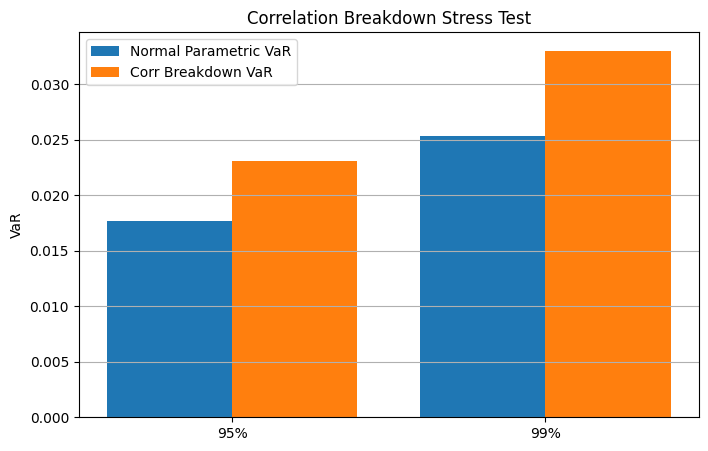

📊 Plots generated successfully.


In [ ]:
plot_risk_report("/content/drive/MyDrive/Datasets/risk_var_cvar_calculations/outputs")